<h1><center>PUC MG - Pontifícia Universidade Católica de Minas Gerais</center></h1>

<h2><center>Pós-Graduação em Ciência de Dados e Big Data</center></h2>

<h3><center>TRABALHO DE CONCLUSÃO DE CURSO</center><br>
TÍTULO: UTILIZAÇÃO DE APRENDIZADO DE MÁQUINA PARA PREVER A TAXA DE VENDA DOS TÍTULOS PÚBLICOS PREFIXADOS DO TESOURO DIRETO<br>
<br>
ALUNO: Edson Mendes do Nascimento Júnior</h3>

<p>Este notebook é referente ao Trabalho de Conclusão de Curso em Ciência de Dados e Big Data.</p>

---


##Importações e Configurações Iniciais

In [ ]:
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 150)
pd.set_option("display.min_rows", 20)

import matplotlib.pyplot as plt

import seaborn as sns # Statistical data visualization

import plotly.graph_objects as go
import plotly.express as px

from datetime import date,datetime
from dateutil.relativedelta import relativedelta

In [ ]:
!pip install yfinance
!pip install investpy

import yfinance as yf

import investpy as inv



     |████████████████████████████████| 5.5MB 8.1MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23442 sha256=4eeedfc04a33ac48da44814d40746c2e9b104802c6eb600a0134ef0bcf9ecc21
  Stored in directory: /root/.cache/pip/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 4.4MB 5.3MB/s 
     |████████████████████████████████| 245kB 34.0MB/s 
     |████████████████████████████████| 512kB 42.2MB/s 
  Created wheel for investpy: filename=investpy-1.0.4-cp37-none-any.whl size=4485184 sha256=5eabd427d9c76f2f06536e2a3ce5080d13d22caac64fce42b699c949df4d53ab
  Stored in directory: /root/.cache/pip/wheels/5e/cb/3f/9af3b261f9a39e8dd47a5ba2f74ed6f127158693457dc7ae36
Successfully built investpy
  Found existing installation: pytz 2018.9
    Uninstalling pytz-2018.9:
      

##1. Funções para Busca e Tratamento de  Dados do Tesouro Direto e dos Indicadores Econômico/Financeiros

In [ ]:
data_inicio = '25/01/2015'
data_fim = '31/01/2020'
data_inicio_treinamento = '2016-01-01'
data_fim_treinamento = '2018-12-31'
data_inicio_teste = '2019-01-01'
data_fim_teste = '2020-01-31'
SEED = '17'

#A função abaixo foi obtida do código Python apresentado no vídeo “TESOURO DIRETO COM PYTHON: Analisando Resgates, Preços e Taxas dos Títulos Públicos”, constante do sítio https://www.youtube.com/watch?v=U3zuklVH6k4.
def busca_titulos_tesouro_direto():
  url = 'https://www.tesourotransparente.gov.br/ckan/dataset/df56aa42-484a-4a59-8184-7676580c81e3/resource/796d2059-14e9-44e3-80c9-2d9e30b405c1/download/PrecoTaxaTesouroDireto.csv'
  df  = pd.read_csv(url, sep=';', decimal=',')
  df['Data Vencimento'] = pd.to_datetime(df['Data Vencimento'], dayfirst=True, format='%d/%m/%Y')
  df['Data Base']       = pd.to_datetime(df['Data Base'], dayfirst=True, format='%d/%m/%Y')
  multi_indice = pd.MultiIndex.from_frame(df.iloc[:, :3])
  df = df.set_index(multi_indice).iloc[: , 3:]  
  return df


In [ ]:
def busca_vendas_tesouro():
  url = "https://www.tesourotransparente.gov.br/ckan/dataset/f0468ecc-ae97-4287-89c2-6d8139fb4343/resource/e5f90e3a-8f8d-4895-9c56-4bb2f7877920/download/VendasTesouroDireto.csv"
  df  = pd.read_csv(url, sep=';', decimal=',')
  df['Vencimento do Titulo'] = pd.to_datetime(df['Vencimento do Titulo'], dayfirst=True)
  df['Data Venda']       = pd.to_datetime(df['Data Venda'], dayfirst=True)
  multi_indice = pd.MultiIndex.from_frame(df.iloc[:, :3])
  df = df.set_index(multi_indice).iloc[: , 3:]  
  return df



In [ ]:
#A função abaixo foi obtida do código Python apresentada no código python obtido do endereço: https://colab.research.google.com/drive/1_t6-vO_Mv1Iv_4Wykexeb81FJkOPY-CI#scrollTo=_k2Wdf_5WQmy
def consulta_bc(codigo_bcb):
  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  df = pd.read_json(url)
  df['data'] = pd.to_datetime(df['data'], dayfirst=True)
  df.set_index('data', inplace=True)
  return df

#obter a taxa Selic
def busca_taxa_selic():
  selic = consulta_bc(432)
  selic = selic.shift(+1) # A selic de um dia será utilizada para prever prever a Taxa de Venda do Título Público do próximo dia
  return selic

#obter a taxa IPCA
def busca_taxa_ipca():
  ipca = consulta_bc(13522)
  ipca = ipca.shift(+1) # O IPCA de um mês será utilizado para prever a Taxa de Venda do Título Público no mes seguinte
  return ipca


#obter a taxa do ibovespa
def busca_ibov():
  
  dfibov = yf.download('^BVSP')[['Adj Close']]
  dfPctChange = dfibov['Adj Close'].pct_change().to_frame()
  dfPctChange.columns = ['Pct Change']
  dfibov = pd.concat([dfibov,dfPctChange],axis=1)
  dfibov['Pct Change']=dfibov['Pct Change'].shift(+1) #O % de variaçao do Ibovespa será utilizado para prever a Taxa de de Venda do Título Público do próximo dia

  lsIbovMensal=[]
  lsIbovAnual=[]
  for i in range(0, len(dfibov)):
    datanegociacao = dfibov.index[i]
    mesanterior = datanegociacao - relativedelta(months=1) #obter a data de 1 mês atrás
    anoanterior = datanegociacao - relativedelta(years=1) #obter a data de 1 ano atrás
    ibovMensal= dfibov[(dfibov.index >= mesanterior) & (dfibov.index <= datanegociacao)]['Pct Change'].sum() #Obter a variação mensal o Ibovespa
    ibovAnual= dfibov[(dfibov.index >= anoanterior) & (dfibov.index <= datanegociacao)]['Pct Change'].sum() #Obter a variação anual do Ibovespa
    lsIbovMensal.append(ibovMensal)
    lsIbovAnual.append(ibovAnual)
  
  dfibov['Pct Change Monthly'] = lsIbovMensal
  dfibov['Pct Change Yearly'] = lsIbovAnual

  return dfibov


##2.Obter informações dos Títulos Públicos e dos Indicadores Econômicos/Financeiros



###2.1 Buscando as informações dos Preços e Taxas Históricas dos Títulos Públicos Negociados
Esse conjunto de dados contém as taxas e preços dos títulos ofertados pelo Tesouro Direto. Refletem o mercado secundário de títulos públicos federais. 

In [ ]:
#Carregar os Preços e Taxas Históricas dos Títulos do Tesouro Direto no dataframe titulos
titulos = busca_titulos_tesouro_direto()
titulos.sort_index(inplace=True)
titulos.head()

Taxa Compra Manha  ...  PU Base Manha
Tipo Titulo                        Data Vencimento Data Base                      ...               
Tesouro IGPM+ com Juros Semestrais 2005-07-01      2004-12-31               9.23  ...        1827.87
                                                   2005-01-03               9.23  ...        1776.51
                                                   2005-01-04               9.26  ...        1777.32
                                                   2005-01-05               9.28  ...        1778.20
                                                   2005-01-06               9.31  ...        1779.01

[5 rows x 5 columns]

In [ ]:
#Verificar a quantidade de linhas no dataframe titulos
print('Total de Linhas no dataframe de Títulos Públicos: ',len(titulos), sep="")

#missing values no dataframe de Títulos Prefixados de Curto Prazos 
print('\nMissing Values no dataframe de Títulos Públicos:\n',titulos.isnull().sum(), sep="")

Total de Linhas no dataframe de Títulos Públicos: 114775

Missing Values no dataframe de Títulos Públicos:
Taxa Compra Manha    0
Taxa Venda Manha     0
PU Compra Manha      0
PU Venda Manha       0
PU Base Manha        0
dtype: int64


In [ ]:
#Apresentar os Tipos de Títulos do Tesouro Direto que são negociados
tipos_titulos = titulos.index.droplevel(level=1).droplevel(level=1).drop_duplicates().to_list()
tipos_titulos

['Tesouro IGPM+ com Juros Semestrais',
 'Tesouro IPCA+',
 'Tesouro IPCA+ com Juros Semestrais',
 'Tesouro Prefixado',
 'Tesouro Prefixado com Juros Semestrais',
 'Tesouro Selic']

###2.2 Títulos Pré-fixado de Curto Prazo


In [ ]:
#Obter as informações dos títulos prefixados de curto prazo
#No período de análise (2016 a 2019) foram negociados 5 títulos prefixados de curto prazo
pre2018 = titulos.loc[('Tesouro Prefixado', '2018-01-01')]
pre2018['DataVencimento']  = datetime.strptime('2018-01-01', '%Y-%m-%d').date()  
pre2019 = titulos.loc[('Tesouro Prefixado', '2019-01-01')]
pre2019['DataVencimento']  = datetime.strptime('2019-01-01', '%Y-%m-%d').date()
pre2020 = titulos.loc[('Tesouro Prefixado', '2020-01-01')]
pre2020['DataVencimento']  = datetime.strptime('2020-01-01', '%Y-%m-%d').date()
pre2021 = titulos.loc[('Tesouro Prefixado', '2021-01-01')]
pre2021['DataVencimento']  = datetime.strptime('2021-01-01', '%Y-%m-%d').date()
pre2022 = titulos.loc[('Tesouro Prefixado', '2022-01-01')]
pre2022['DataVencimento']  = datetime.strptime('2022-01-01', '%Y-%m-%d').date()


#FILTRAR as taxas de cada Título Prefixado de acordo com o tempo que o título foi vendido
pre2018 = pre2018[pre2018.index >= data_inicio_treinamento]
pre2018 = pre2018[pre2018.index < '2016-01-28']
pre2019 = pre2019[pre2019.index >= '2016-01-28'] 
pre2019 = pre2019[pre2019.index < '2017-02-10'] 
pre2020 = pre2020[pre2020.index >= '2017-02-10'] 
pre2020 = pre2020[pre2020.index < '2018-02-08'] 
pre2021 = pre2021[pre2021.index >= '2018-02-08'] 
pre2021 = pre2021[pre2021.index < '2019-02-04'] 
pre2022 = pre2022[pre2022.index >= '2019-02-04'] 
pre2022 = pre2022[pre2022.index <= data_fim_teste] 

#Montar o dataframe pre_curto_prazo com a concatenação dos 5 títulos préfixados negociados entre 2016 e 2019
pre_curto_prazo = pd.concat([pre2018,pre2019,pre2020,pre2021,pre2022])

#quantidade de linhas do dataframe de Títulos Prefixados de Curto Prazos
print('Total de Linhas no dataframe de Títulos Prefixados de Curto Prazo: ',len(pre_curto_prazo), sep="")

#missing values no dataframe de Títulos Prefixados de Curto Prazos 
print('\nMissing Values no dataframe de Títulos Prefixados de Curto Prazo:\n',pre_curto_prazo.isnull().sum(), sep="")


Total de Linhas no dataframe de Títulos Prefixados de Curto Prazo: 1016

Missing Values no dataframe de Títulos Prefixados de Curto Prazo:
Taxa Compra Manha    0
Taxa Venda Manha     0
PU Compra Manha      0
PU Venda Manha       0
PU Base Manha        0
DataVencimento       0
dtype: int64


###2.3 Buscar Informações Econômicas/Finaneiras que podem influenciar nas Taxas de Vendas dos Títulos do Tesouro Direto :
 * Juros Futuros 
 * Selic 
 * IPCA 
 * Ibovespa


In [ ]:
#obter os dados das taxas de juros futuros - DI de 2, 3 e 5 anos
juros_futuros_dois_anos = inv.get_bond_historical_data('Brazil 2Y', from_date=data_inicio, to_date=data_fim)[['Close']]
juros_futuros_dois_anos = juros_futuros_dois_anos.shift(+1) #Os juros de fechamento de um dia serão utilizados para cálculo da taxa do dia seguinte
juros_futuros_tres_anos = inv.get_bond_historical_data('Brazil 3Y', from_date=data_inicio, to_date=data_fim)[['Close']]
juros_futuros_tres_anos = juros_futuros_tres_anos.shift(+1) #Os juros de fechamento de um dia serão utilizados para cálculo da taxa do dia seguinte
juros_futuros_cinco_anos = inv.get_bond_historical_data('Brazil 5Y', from_date=data_inicio, to_date=data_fim)[['Close']]
juros_futuros_cinco_anos = juros_futuros_cinco_anos.shift(+1) #Os juros de fechamento de um dia serão utilizados para cálculo da taxa do dia seguinte


In [ ]:
#filtrar os dataframes de juros futuros de acordo com os períodos de treino e teste do Algoritmo de Machine Learning
juros_futuros_dois_anos = juros_futuros_dois_anos[juros_futuros_dois_anos.index >= data_inicio_treinamento]
juros_futuros_dois_anos = juros_futuros_dois_anos[juros_futuros_dois_anos.index <= data_fim_teste]
juros_futuros_tres_anos = juros_futuros_tres_anos[juros_futuros_tres_anos.index >= data_inicio_treinamento]
juros_futuros_tres_anos = juros_futuros_tres_anos[juros_futuros_tres_anos.index <= data_fim_teste]
juros_futuros_cinco_anos = juros_futuros_cinco_anos[juros_futuros_cinco_anos.index >= data_inicio_treinamento]
juros_futuros_cinco_anos = juros_futuros_cinco_anos[juros_futuros_cinco_anos.index <= data_fim_teste]

#quantidade de linhas dos dataframes de juros futuros
print('Total de Linhas Juros Futuros 2 anos: ',len(juros_futuros_dois_anos), sep="")
print('Total de Linhas Juros Futuros 3 anos: ',len(juros_futuros_tres_anos), sep="")
print('Total de Linhas Juros Futuros 5 anos: ',len(juros_futuros_cinco_anos), sep="")

#missing values dos dataframes de juros futuros
print('\nMissing Values dataframe de Juros Futuros 2 anos:\n',juros_futuros_dois_anos.isnull().sum(), sep="")
print('\nMissing Values dataframe de Juros Futuros 3 anos:\n',juros_futuros_tres_anos.isnull().sum(), sep="")
print('\nMissing Values dataframe de Juros Futuros 5 anos:\n',juros_futuros_cinco_anos.isnull().sum(), sep="")

Total de Linhas Juros Futuros 2 anos: 1047
Total de Linhas Juros Futuros 3 anos: 1047
Total de Linhas Juros Futuros 5 anos: 1053

Missing Values dataframe de Juros Futuros 2 anos:
Close    0
dtype: int64

Missing Values dataframe de Juros Futuros 3 anos:
Close    0
dtype: int64

Missing Values dataframe de Juros Futuros 5 anos:
Close    0
dtype: int64


In [ ]:
#obter a taxa Selic
dfselic = busca_taxa_selic()

#filtrar o dataframes dfselic de acordo com os períodos de treino e teste do Algoritmo de Machine Learning
dfselic = dfselic[dfselic.index >= data_inicio_treinamento]
dfselic = dfselic[dfselic.index <= data_fim_teste]

#imprimir total de linhas e missing values do dfselic
print('Total de Linhas do dataframe Selic : ',len(dfselic), sep="")
print('\nMissing Values do dataframe Selic:\n',dfselic.isnull().sum(), sep="")

Total de Linhas do dataframe Selic : 1492

Missing Values do dataframe Selic:
valor    0
dtype: int64


In [ ]:
#Obter os valores das Taxa IPCA de 12 meses
dfipca = busca_taxa_ipca()

#Criar as colunas Mes e Ano para facilitar o filtro
dfipca['Mes'] = dfipca.index.month
dfipca['Ano'] = dfipca.index.year

#filtrar o dfipca de acordo com os períodos de treino e teste do Algoritmo de Machine Learning
dfipca = dfipca[dfipca.index >= datetime.strptime(data_inicio_treinamento, '%Y-%m-%d').replace(day=1)]
dfipca = dfipca[dfipca.index <= data_fim_teste]

#imprimir total de linhas e missing values do dfselic
print('Total de Linhas do dataframe IPCA : ',len(dfipca), sep="")
print('\nMissing Values do dataframe IPCA :\n',dfipca.isnull().sum(), sep="")

Total de Linhas do dataframe IPCA : 49

Missing Values do dataframe IPCA :
valor    0
Mes      0
Ano      0
dtype: int64


In [ ]:
#Obter as informações do índice Ibovespa
dfibov = busca_ibov()

#filtrar o dataframe dfibov de acordo com os períodos de treino e teste do Algoritmo de Machine Learning
dfibov = dfibov[dfibov.index >= data_inicio_treinamento]
dfibov = dfibov[dfibov.index <= data_fim_teste]

#imprimir total de linhas e missing values do dfibov
print('Total de Linhas do dataframe Ibovespa : ',len(dfibov), sep="")
print('\nMissing Values do dataframe Ibovespa :\n',dfibov.isnull().sum(), sep="")

[*********************100%***********************]  1 of 1 completed
Total de Linhas do dataframe Ibovespa : 1011

Missing Values do dataframe Ibovespa :
Adj Close             0
Pct Change            0
Pct Change Monthly    0
Pct Change Yearly     0
dtype: int64


In [ ]:
dfibov.head()

,Adj Close,Pct Change,Pct Change Monthly,Pct Change Yearly
Date,,,,
2016-01-04,42141.0,-0.006964,-0.032941,-0.116482
2016-01-05,42419.0,-0.027889,-0.093737,-0.144371
2016-01-06,41773.0,0.006597,-0.087140,-0.107878
2016-01-07,40695.0,-0.015229,-0.102369,-0.102597
2016-01-08,40612.0,-0.025806,-0.105930,-0.138589


###2.4 Criar um Dataframe com as informações dos Títulos Públicos e com os indicadores adicionais 

In [ ]:
#A função irá criar um único dataframe a partir das informações dos dataframes de Títulos Públicos, Selic, IPCA, Ibovespa, Juros Futuros de 2 anos, 
#Juros Futuros 3 anos e Juros Futuros 5 anos
#O dataframe gerado por essa função será utilizado para treinar e testar os Modelos de Machine Learning
def merge_titulos_com_indicadores(dfTitulos, dfSelic, dfIPCA, dfIbovespa, dfJurosFuturosDoisAnos, dfJurosFuturosTresAnos, dfJurosFuturosCincoAnos):
  
  #acrescentar quantos anos restam para o vencimento do título
  dfTitulos2 = dfTitulos.copy()
  dfTitulos2['AnosVencimento'] = (dfTitulos2['DataVencimento'] - dfTitulos2.index.date)/np.timedelta64(1, "Y")
  df = pd.merge(dfTitulos['Taxa Venda Manha'],dfTitulos2['AnosVencimento'],how='left', left_index=True,right_index=True )
  df.columns = ['TaxaVendaTítulo','AnosVencimento']

  #acrescentar a informação da TaxaSelic
  df = pd.merge(df,dfSelic,how='left', left_index=True,right_index=True )
  df.columns = ['TaxaVendaTítulo','AnosVencimento','Selic']

  #acrescentar a informação da Taxa IPCA
  lsIPCA=[]
  for i in range(0, len(dfTitulos)):
    datanegociacao = dfTitulos.index[i]
    taxaipcamesanterior = dfIPCA.loc[(dfIPCA['Mes'] == datanegociacao.month) & (dfIPCA['Ano'] == datanegociacao.year)]['valor'][0]
    lsIPCA.append(taxaipcamesanterior)
  df['TaxaIPCA'] = lsIPCA

  #acrescentar as informações das Taxas de Juros Futuros de 2, 3 e 5 anos
  dfJuros = pd.concat([dfJurosFuturosDoisAnos, dfJurosFuturosTresAnos, dfJurosFuturosCincoAnos], axis=1)
  df = pd.merge(df,dfJuros,how='left', left_index=True,right_index=True )
  df.columns = ['TaxaVendaTítulo','AnosVencimento','Selic','TaxaIPCA','TaxaJuros2Anos','TaxaJuros3Anos','TaxaJuros5Anos']

  #acrescentar a taxa de variação do Ibovespa
  df = pd.merge(df,dfIbovespa[['Pct Change','Pct Change Monthly','Pct Change Yearly']],how='left', left_index=True,right_index=True )
  df.columns = ['TaxaVendaTítulo','AnosVencimento','Selic','TaxaIPCA','TaxaJuros2Anos','TaxaJuros3Anos','TaxaJuros5Anos','PctIbovespaDiario','PctIbovespaMensal','PctIbovespaAnual']

  return df


In [ ]:
strNomeTitulo = 'Pré Fixado de Curto Prazo'
dfTitulosIndicadores = merge_titulos_com_indicadores(pre_curto_prazo,dfselic,dfipca,dfibov,juros_futuros_dois_anos, juros_futuros_tres_anos, juros_futuros_cinco_anos)
dfTitulosIndicadores.head()

,TaxaVendaTítulo,AnosVencimento,Selic,TaxaIPCA,TaxaJuros2Anos,TaxaJuros3Anos,TaxaJuros5Anos,PctIbovespaDiario,PctIbovespaMensal,PctIbovespaAnual
Data Base,,,,,,,,,,
2016-01-04,16.53,1.993196,14.25,10.67,16.530,16.680,16.560,-0.006964,-0.032941,-0.116482
2016-01-05,16.50,1.990458,14.25,10.67,16.455,16.655,16.500,-0.027889,-0.093737,-0.144371
2016-01-06,16.21,1.987720,14.25,10.67,16.160,16.340,16.165,0.006597,-0.087140,-0.107878
2016-01-07,16.07,1.984983,14.25,10.67,16.025,16.255,16.040,-0.015229,-0.102369,-0.102597
2016-01-08,16.15,1.982245,14.25,10.67,16.100,16.305,16.175,-0.025806,-0.105930,-0.138589


In [ ]:
#Verificar a quantidade de linhas no dataframe TitulosIndicadores
print('Total de Linhas no dataframe de TítulosIndicadores: ',len(dfTitulosIndicadores), sep="")
#missing values no dataframe de Títulos Prefixados de Curto Prazos 
print('\nMissing Values no dataframe de TítulosIndicadores:\n',dfTitulosIndicadores.isnull().sum(), sep="")

Total de Linhas no dataframe de TítulosIndicadores: 1016

Missing Values no dataframe de TítulosIndicadores:
TaxaVendaTítulo      0
AnosVencimento       0
Selic                0
TaxaIPCA             0
TaxaJuros2Anos       3
TaxaJuros3Anos       2
TaxaJuros5Anos       0
PctIbovespaDiario    8
PctIbovespaMensal    8
PctIbovespaAnual     8
dtype: int64


In [ ]:
#Tratar os Missing Values (Valores Ausentes)

#3 linhas com o missing values no atributo TaxaJuros2Anos 
dfTitulosIndicadores['TaxaJuros2Anos'].fillna(method='ffill',inplace = True)   #ffill => preencher com a última taxa antes do Missing Value
#2 linhas com o missing values no atributo TaxaJuros3Anos 
dfTitulosIndicadores['TaxaJuros3Anos'].fillna(method='ffill',inplace = True)   #ffill => preencher com a última taxa antes do Missing Value
#0 linha com o missing values no atributo TaxaJuros5Anos 
dfTitulosIndicadores['TaxaJuros5Anos'].fillna(method='ffill',inplace = True) #ffill => preencher com a última taxa antes do Missing Value

#8 linhas com o missing values no atributo PctIbovespa         
dfTitulosIndicadores['PctIbovespaDiario'].fillna(0,inplace = True) #colocar zero pois não houve negociação da Bovespa nesses dias
dfTitulosIndicadores['PctIbovespaMensal'].fillna(method='ffill',inplace = True) #preencher com o último valor do PctIbovespaMensal antes do Missing Value
dfTitulosIndicadores['PctIbovespaAnual'].fillna(method='ffill',inplace = True)  #preencher com o último valor do PctIbovespaAnual antes do Missing Value

#verificar os missing values após a imputação acima
print('\nMissing Values no dataframe de TítulosIndicadores após o tratamento:\n',dfTitulosIndicadores.isnull().sum(), sep="")


Missing Values no dataframe de TítulosIndicadores após o tratamento:
TaxaVendaTítulo      0
AnosVencimento       0
Selic                0
TaxaIPCA             0
TaxaJuros2Anos       0
TaxaJuros3Anos       0
TaxaJuros5Anos       0
PctIbovespaDiario    0
PctIbovespaMensal    0
PctIbovespaAnual     0
dtype: int64


In [ ]:
#Criar uma cópia do dataframe de TítulosIndicadores antes da análise exploratória
dfTitulosIndicadoresOriginal = dfTitulosIndicadores.copy()

# 3. Análise Exploratória dos Dados

## Histórico das Taxas dos Títulos Préfixados de 2016 a 2019

In [ ]:
#Descrição estatística dos Títulos Préfixados de curto prazo
pre_curto_prazo.describe()

,Taxa Compra Manha,Taxa Venda Manha,PU Compra Manha,PU Venda Manha,PU Base Manha
count,1016.000000,1016.000000,1016.000000,1016.000000,1016.000000
mean,9.195571,9.301811,811.927156,810.028868,809.743317
std,2.581374,2.561012,52.857297,52.532056,52.577575
min,4.820000,4.940000,650.480000,649.510000,649.120000
25%,7.737500,7.857500,783.137500,781.707500,781.422500
50%,8.670000,8.790000,812.125000,810.120000,809.820000
75%,10.910000,11.030000,849.387500,847.182500,846.947500
max,16.470000,16.530000,912.720000,910.730000,910.550000


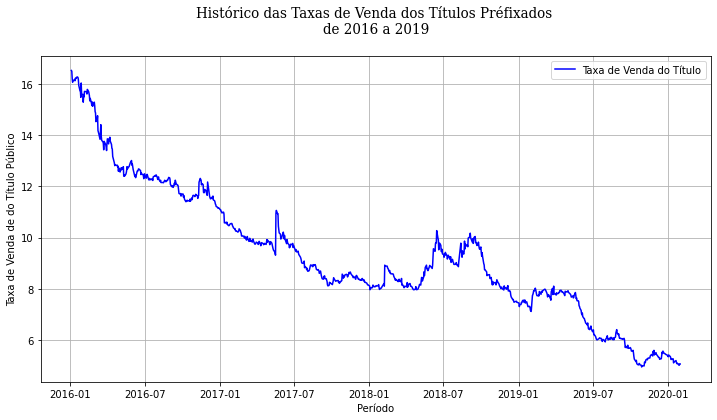

In [ ]:
#Plotagem dos dados de teste e dados previstos
plt.figure(figsize=(12,6))
plt.plot(pre_curto_prazo.index, pre_curto_prazo['Taxa Venda Manha'], color = 'blue', label = 'Taxa de Venda do Título')
strTitle = 'Histórico das Taxas de Venda dos Títulos Préfixados \nde 2016 a 2019\n' 
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 13.5,
        }
plt.title(strTitle, fontdict=font)
plt.xlabel('Período')
plt.ylabel('Taxa de Venda de do Título Público')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#Obtendo quando ocorreu a maior valor da Taxa de Venda do Título Público
max_titulo_id = pre_curto_prazo['Taxa Venda Manha'].argmax()
print(pre_curto_prazo.iloc[max_titulo_id][['Taxa Venda Manha']])


Taxa Venda Manha    16.53
Name: 2016-01-04 00:00:00, dtype: object


In [ ]:
#Obtendo quando ocorreu a menor valor da Taxa de Venda do Título Público
min_titulo_id = pre_curto_prazo['Taxa Venda Manha'].argmin()
print(pre_curto_prazo.iloc[min_titulo_id][['Taxa Venda Manha']])

Taxa Venda Manha    4.94
Name: 2019-10-29 00:00:00, dtype: object


## Taxa Selic

In [ ]:
#Descrição estatística da Taxa Selic
dfselic.describe()

,valor
count,1492.000000
mean,9.148961
std,3.467593
min,4.500000
25%,6.500000
50%,7.000000
75%,13.750000
max,14.250000


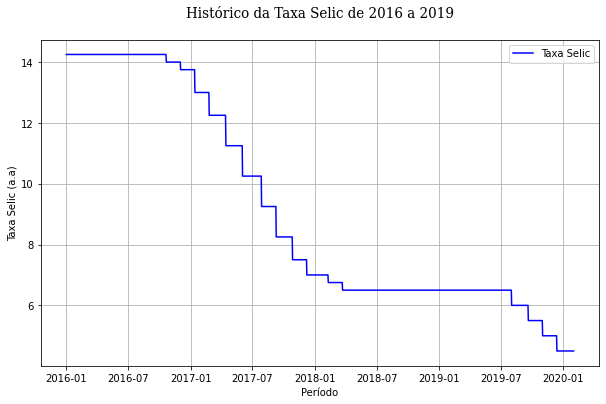

In [ ]:
#Plotagem da evolução do histórico da Taxa Selic
plt.figure(figsize=(10,6))
plt.plot(dfselic.index, dfselic['valor'], color = 'blue', label = 'Taxa Selic')
strTitle = 'Histórico da Taxa Selic de 2016 a 2019\n' 
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 13.5,
        }
plt.title(strTitle, fontdict=font)
plt.xlabel('Período')
plt.ylabel('Taxa Selic (a.a)')
plt.legend()
plt.grid(True)
#plt.savefig('lstm2.pdf')
plt.show()


## Juros Futuros

In [ ]:
#Para Facilitar as análises, os Juros Futuros de 2,5 e 10 anos serão juntados em apenas um dataframe
dfJurosFuturos = pd.concat([juros_futuros_dois_anos, juros_futuros_tres_anos, juros_futuros_cinco_anos], axis=1)
dfJurosFuturos.columns = ['TaxaJuros2Anos','TaxaJuros3Anos','TaxaJuros5Anos']


In [ ]:
#Descrição estatística dos Juros Futuros
dfJurosFuturos.describe()

,TaxaJuros2Anos,TaxaJuros3Anos,TaxaJuros5Anos
count,1047.000000,1047.000000,1053.000000
mean,9.045878,9.480241,9.942922
std,2.669007,2.471630,2.253780
min,4.725000,5.100000,5.845000
25%,7.330000,8.030000,8.525000
50%,8.410000,9.105000,9.830000
75%,11.117500,11.105000,11.280000
max,16.530000,16.710000,16.655000


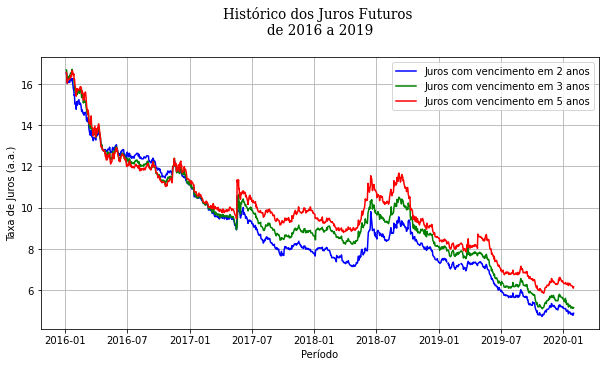

In [ ]:
#Plotagem dos dados históricos dos Juros Futuros
plt.figure(figsize=(10,5))
plt.plot(dfJurosFuturos.index, dfJurosFuturos['TaxaJuros2Anos'], color = 'blue', label = 'Juros com vencimento em 2 anos')
plt.plot(dfJurosFuturos.index, dfJurosFuturos['TaxaJuros3Anos'], color = 'green', label = 'Juros com vencimento em 3 anos')
plt.plot(dfJurosFuturos.index, dfJurosFuturos['TaxaJuros5Anos'], color = 'red', label = 'Juros com vencimento em 5 anos')
strTitle = 'Histórico dos Juros Futuros \nde 2016 a 2019\n' 
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 13.5,
        }
plt.title(strTitle, fontdict=font)
plt.xlabel('Período')
plt.ylabel('Taxa de Juros (a.a.)')
plt.legend()
plt.grid(True)
#plt.savefig('lstm2.pdf')
plt.show()

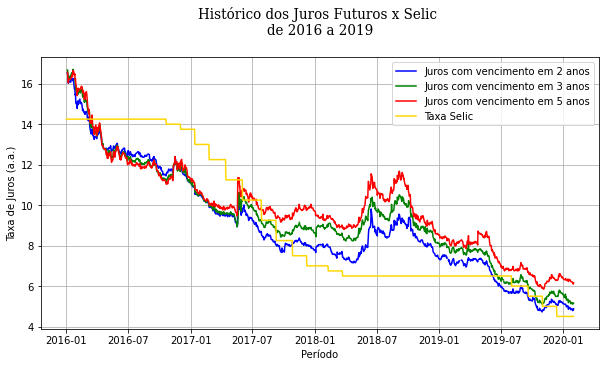

In [ ]:
#Plotagem dos dados históricos dos Juros Futuros x Selic
plt.figure(figsize=(10,5))
plt.plot(dfJurosFuturos.index, dfJurosFuturos['TaxaJuros2Anos'], color = 'blue', label = 'Juros com vencimento em 2 anos')
plt.plot(dfJurosFuturos.index, dfJurosFuturos['TaxaJuros3Anos'], color = 'green', label = 'Juros com vencimento em 3 anos')
plt.plot(dfJurosFuturos.index, dfJurosFuturos['TaxaJuros5Anos'], color = 'red', label = 'Juros com vencimento em 5 anos')
plt.plot(dfselic.index, dfselic['valor'], color = 'gold', label = 'Taxa Selic')
strTitle = 'Histórico dos Juros Futuros x Selic \nde 2016 a 2019\n' 
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 13.5,
        }
plt.title(strTitle, fontdict=font)
plt.xlabel('Período')
plt.ylabel('Taxa de Juros (a.a.)')
plt.legend()
plt.grid(True)
#plt.savefig('lstm2.pdf')
plt.show()

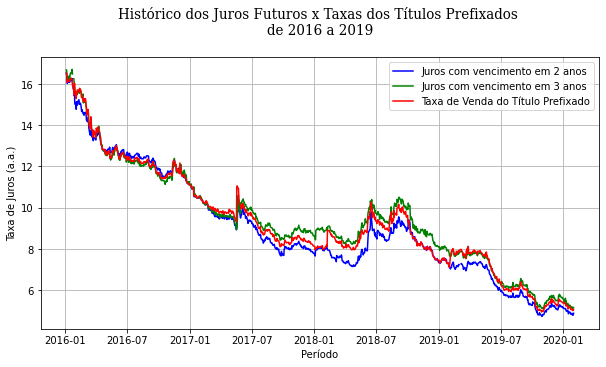

In [ ]:
#Plotagem dos dados históricos dos Juros Futuros x Taxas de Venda dos Títulos Prefixados
plt.figure(figsize=(10,5))
plt.plot(dfJurosFuturos.index, dfJurosFuturos['TaxaJuros2Anos'], color = 'blue', label = 'Juros com vencimento em 2 anos')
plt.plot(dfJurosFuturos.index, dfJurosFuturos['TaxaJuros3Anos'], color = 'green', label = 'Juros com vencimento em 3 anos')
plt.plot(pre_curto_prazo.index, pre_curto_prazo['Taxa Venda Manha'], color = 'red', label = 'Taxa de Venda do Título Prefixado')
strTitle = 'Histórico dos Juros Futuros x Taxas dos Títulos Prefixados \nde 2016 a 2019\n' 
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 13.5,
        }
plt.title(strTitle, fontdict=font)
plt.xlabel('Período')
plt.ylabel('Taxa de Juros (a.a.)')
plt.legend()
plt.grid(True)
#plt.savefig('lstm2.pdf')
plt.show()

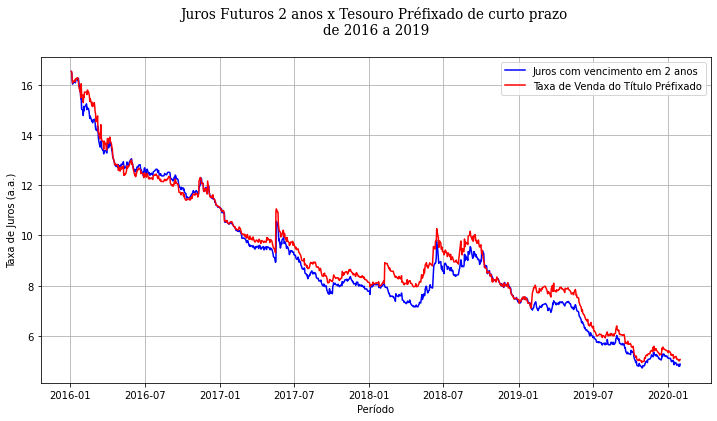

In [ ]:
#Plotagem dos dados de teste e dados previstos
plt.figure(figsize=(12,6))
plt.plot(juros_futuros_dois_anos.index, juros_futuros_dois_anos['Close'], color = 'blue', label = 'Juros com vencimento em 2 anos')
#plt.plot(juros_futuros_tres_anos.index, juros_futuros_tres_anos['Close'], color = 'green', label = 'Juros com vencimento em 5 anos')
plt.plot(pre_curto_prazo.index, pre_curto_prazo['Taxa Venda Manha'], color = 'red', label = 'Taxa de Venda do Título Préfixado')
strTitle = 'Juros Futuros 2 anos x Tesouro Préfixado de curto prazo \nde 2016 a 2019\n' 
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 13.5,
        }
plt.title(strTitle, fontdict=font)
plt.xlabel('Período')
plt.ylabel('Taxa de Juros (a.a.)')
plt.legend()
plt.grid(True)
#plt.savefig('lstm2.pdf')
plt.show()

## Taxa IPCA

In [ ]:
#Descrição estatística da Taxa IPCA
dfipca[['valor']].describe()

,valor
count,49.000000
mean,5.025714
std,2.554007
min,2.460000
25%,2.950000
50%,4.190000
75%,6.290000
max,10.710000


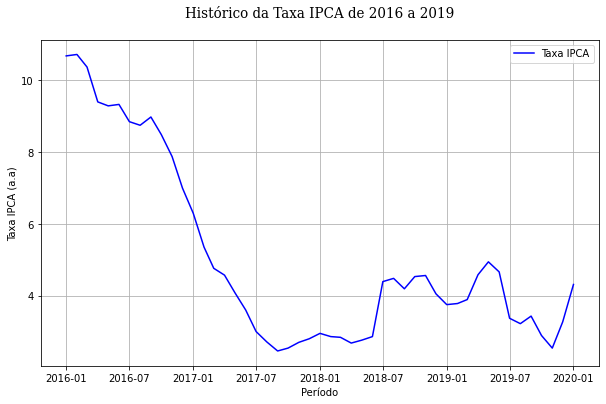

In [ ]:
#Plotagem da evolução do histórico da Taxa IPCA
plt.figure(figsize=(10,6))
plt.plot(dfipca.index, dfipca['valor'], color = 'blue', label = 'Taxa IPCA')
strTitle = 'Histórico da Taxa IPCA de 2016 a 2019\n' 
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 13.5,
        }
plt.title(strTitle, fontdict=font)
plt.xlabel('Período')
plt.ylabel('Taxa IPCA (a.a)')
plt.legend()
plt.grid(True)
#plt.savefig('lstm2.pdf')
plt.show()


## Índice Ibovespa

In [ ]:
#Descrição estatística da Taxa IPCA
dfibov.describe()

,Adj Close,Pct Change,Pct Change Monthly,Pct Change Yearly
count,1011.000000,1011.000000,1011.000000,1011.000000
mean,76742.382789,0.001057,0.022954,0.202798
std,19184.863535,0.013673,0.063133,0.135908
min,37497.000000,-0.087992,-0.197756,-0.237369
25%,62160.000000,-0.006589,-0.013397,0.156471
50%,75688.000000,0.001163,0.022322,0.223180
75%,93620.500000,0.009043,0.063089,0.278892
max,119528.000000,0.065972,0.237906,0.591814


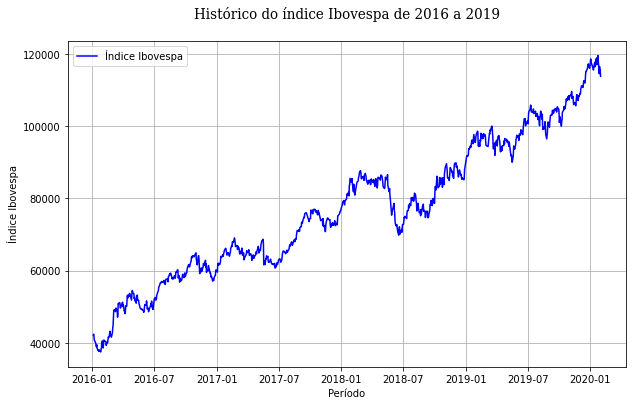

In [ ]:
#Plotagem da evolução do histórico do índice Ibovespa
plt.figure(figsize=(10,6))
plt.plot(dfibov.index, dfibov['Adj Close'], color = 'blue', label = 'Índice Ibovespa')
strTitle = 'Histórico do índice Ibovespa de 2016 a 2019\n' 
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 13.5,
        }
plt.title(strTitle, fontdict=font)
plt.xlabel('Período')
plt.ylabel('Índice Ibovespa')
plt.legend()
plt.grid(True)
#plt.savefig('lstm2.pdf')
plt.show()


## Dataframe com as Títulos e Indicadores Econômico/Financeiros

In [ ]:
#Descrição estatística do dfTitulosIndicadores
dfTitulosIndicadores[['AnosVencimento']].describe()

,AnosVencimento
count,1016.000000
mean,2.397932
std,0.291074
min,1.891894
25%,2.146519
50%,2.398407
75%,2.647556
max,2.926823


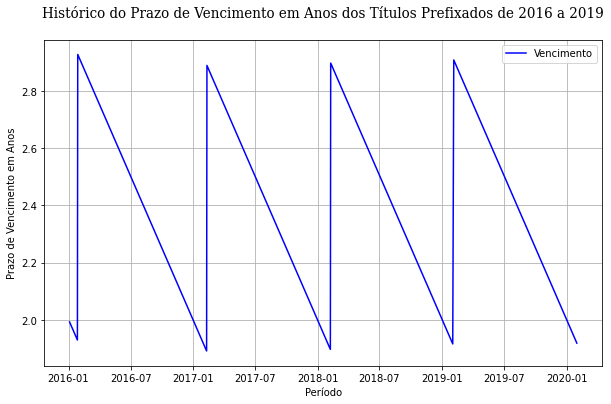

In [ ]:
#Plotagem da evolução do histórico do índice Ibovespa
plt.figure(figsize=(10,6))
plt.plot(dfTitulosIndicadores.index, dfTitulosIndicadores['AnosVencimento'], color = 'blue', label = 'Vencimento')
strTitle = 'Histórico do Prazo de Vencimento em Anos dos Títulos Prefixados de 2016 a 2019\n' 
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 13.5,
        }
plt.title(strTitle, fontdict=font)
plt.xlabel('Período')
plt.ylabel('Prazo de Vencimento em Anos')
plt.legend()
plt.grid(True)
#plt.savefig('lstm2.pdf')
plt.show()


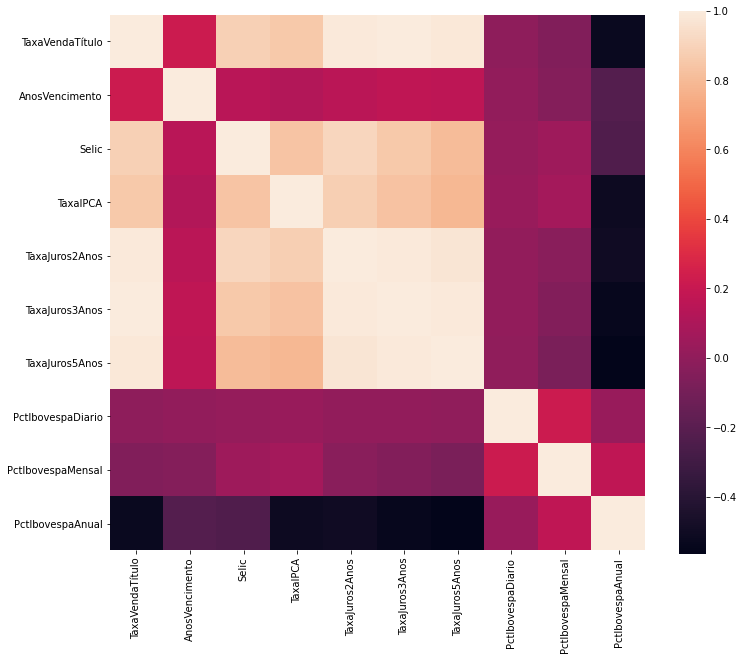

In [ ]:
#Correlation matrix to look at the correlation btw the variables: 
correlation_matrix = dfTitulosIndicadores.corr()
f, ax= plt.subplots(figsize=(12,10))
sns.heatmap(correlation_matrix,vmax=1, square=True)

# 4. Modelos de Aprendizad de Máquina (Machine Learning)

## 4.1 Criar funções que serão utilizadas por todos os Modelos

In [ ]:
# Importa a library LinearRegression --> Para treinamento da Regressão Linear
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math
from sklearn.svm import SVR

# Library para statmodels
import statsmodels.api as sm

#Definir funções que serão utilizadas por todos os modelos de predição
#Imprimir Gráfico da predição
def imprimir_graficos_predicao(strModel, y_target, arPredict):
  
  df_Test_Predicted = y_target.copy()
  df_Test_Predicted['TaxaPrevista'] = arPredict

  #Plotagem dos dados de teste e dados previstos
  plt.figure(figsize=(16,8))
  plt.plot(y_target.index, y_target, color = 'blue', label = 'Taxa de Venda Real')
  plt.plot(y_target.index, arPredict, color = 'red', label = 'Taxa de Venda Prevista')
  strTitle = 'Tipo de Título do Tesouro Direto:  ' + strNomeTitulo +'\n Comparação da Taxa Target de Venda do Título Público com a Prevista pelo Modelo de Regressão: ' + strModel + '\n' 
  font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 13.5,
        }
  plt.title(strTitle, fontdict=font)
  plt.xlabel('Período')
  plt.ylabel('Taxa de Venda de do Título Público')
  plt.legend()
  plt.grid(True)
  #plt.savefig('lstm2.pdf')
  plt.show()

# Function to plot interactive plots using Plotly Express
def imprimir_graficos_predicao2(strModel, y_target, arPredict):
  strTitle = 'Tipo de Título do Tesouro Direto:  ' + strNomeTitulo +'\n Comparação da Taxa Target de Venda do Título Público com a Prevista pelo Modelo de Regressão: ' + strModel + '\n' 
  fig = px.line(title = strTitle)
  fig.add_scatter(x = y_target.index.date, y = y_target, name = 'Taxa de Venda Real')
  #fig.add_scatter(x = y_target.index.date, y = arPredict, name = 'Taxa de Venda Prevista')
  fig.show()

#Imprimir mensagens de erro da predição
def imprimir_scores_predicao(strModel, y_target, arPredict):
  #print(strModel, ' - R2: ', r2_score(y_target, arPredict))
  print(strModel, ' - MAE:  ', mean_absolute_error(y_target, arPredict))
  #print(strModel, ' - MSE: ', mean_squared_error(y_target, arPredict))
  print(strModel, ' - RMSE: ', np.sqrt(mean_squared_error(y_target, arPredict)))

## Modelo 1 - Regressão Linear apenas com Juros Futuros de 2 e 3 anos

### Criar os dataframes de Treinamento e Teste

In [ ]:
#Considerar nesse modelo apenas as features TaxaJuros2Anos e TaxaJuros3Anos
dfTitulosIndicadores = dfTitulosIndicadoresOriginal.copy()
dfTitulosIndicadores.drop(columns = ['Selic'], axis = 1, inplace=True)
dfTitulosIndicadores.drop(columns = ['TaxaIPCA'], axis = 1, inplace=True)
dfTitulosIndicadores.drop(columns = ['PctIbovespaDiario'], axis = 1, inplace=True)
dfTitulosIndicadores.drop(columns = ['PctIbovespaMensal'], axis = 1, inplace=True)
dfTitulosIndicadores.drop(columns = ['PctIbovespaAnual'], axis = 1, inplace=True)
dfTitulosIndicadores.drop(columns = ['AnosVencimento'], axis = 1, inplace=True)
dfTitulosIndicadores.drop(columns = ['TaxaJuros5Anos'], axis = 1, inplace=True)


In [ ]:
dfTitulosIndicadores.head()

,TaxaVendaTítulo,TaxaJuros2Anos,TaxaJuros3Anos
Data Base,,,
2016-01-04,16.53,16.530,16.680
2016-01-05,16.50,16.455,16.655
2016-01-06,16.21,16.160,16.340
2016-01-07,16.07,16.025,16.255
2016-01-08,16.15,16.100,16.305


In [ ]:
#Criar os dataframe de Treinamento e Teste
df_train =  dfTitulosIndicadores[dfTitulosIndicadores.index >= data_inicio_treinamento]
df_train =  df_train[df_train.index <= data_fim_treinamento]
df_test = dfTitulosIndicadores[dfTitulosIndicadores.index >= data_inicio_teste]
df_test =  df_test[df_test.index <= data_fim_teste]

X_train = df_train.iloc[:,1:]
y_train = df_train[['TaxaVendaTítulo']]

X_test = df_test.iloc[:,1:]
y_test = df_test[['TaxaVendaTítulo']]

### Treinar e Testar o Modelo


In [ ]:
# Instancia o objeto
regressao_linear = LinearRegression( )

# Treina o modelo 
regressao_linear.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Valor do intercepto
regressao_linear.intercept_

array([-0.11476975])

In [ ]:
# Valor dos Coeficientes
regressao_linear.coef_

array([[0.42905328, 0.58249255]])

In [ ]:
X_train.columns

Index(['TaxaJuros2Anos', 'TaxaJuros3Anos'], dtype='object')

In [ ]:
X_test.head()

,TaxaJuros2Anos,TaxaJuros3Anos
Data Base,,
2019-01-02,7.35,8.11
2019-01-03,7.31,7.93
2019-01-04,7.30,7.97
2019-01-07,7.35,8.01
2019-01-08,7.44,8.09


In [ ]:
y_test.head()

,TaxaVendaTítulo
Data Base,
2019-01-02,7.44
2019-01-03,7.30
2019-01-04,7.38
2019-01-07,7.38
2019-01-08,7.46


In [ ]:
# Realizar predições com o modelo de Regressão Linear
predicted_rl = regressao_linear.predict(X_test)

In [ ]:
predicted_rl

array([[7.76278638],
       [7.64077559],
       [7.65978476],
       [7.70453712],
       [7.78975132],
       [7.77503268],
       [7.74452999],
       [7.83419104],
       [7.8371035 ],
       [7.76338283],
       [7.82560997],
       [7.85886881],
       [7.84890968],
       [7.80231027],
       [7.76369548],
       [7.7590923 ],
       [7.64904401],
       [7.66651878],
       [7.63081645],
       [7.65089104],
       [7.55709578],
       [7.53655222],
       [7.39922634],
       [7.34006798],
       [7.38328595],
       [7.41363233],
       [7.44858188],
       [7.56567685],
       [7.64782226],
       [7.65640332],
       [7.58712951],
       [7.4672784 ],
       [7.39340141],
       [7.34313676],
       [7.42988536],
       [7.40658565],
       [7.48199704],
       [7.51356516],
       [7.44842556],
       [7.50958727],
       [7.54391154],
       [7.49455599],
       [7.5524926 ],
       [7.57287984],
       [7.61625414],
       [7.60889482],
       [7.55556139],
       [7.477

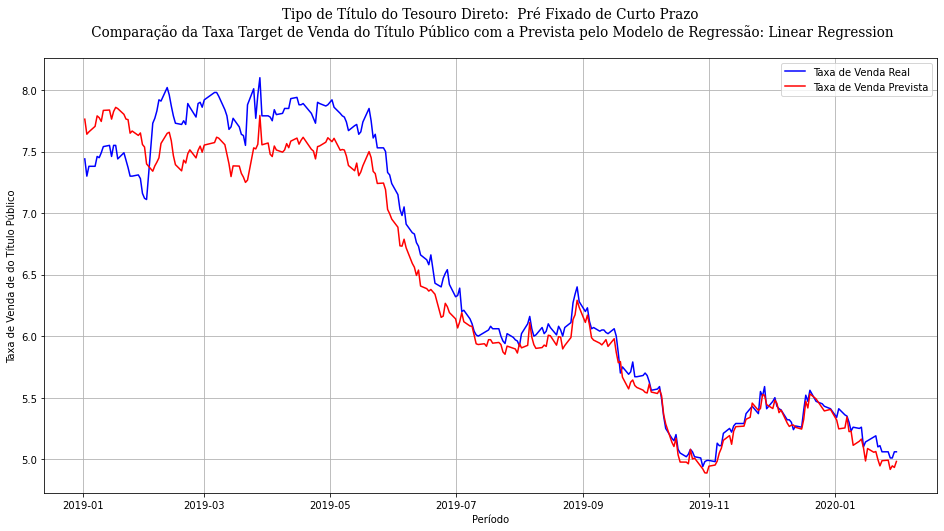

In [ ]:
#imprimir o gráfico do Modelo
imprimir_graficos_predicao('Linear Regression', y_test, predicted_rl)

In [ ]:
imprimir_scores_predicao("Regressão Linear", y_test, predicted_rl)

Regressão Linear  - MAE:   0.18391884941674697
Regressão Linear  - RMSE:  0.22626880670408178


In [ ]:
y_test[y_test.index>= '2019-02-01'].head()

,TaxaVendaTítulo
Data Base,
2019-02-01,7.11
2019-02-04,7.73
2019-02-05,7.77
2019-02-06,7.83
2019-02-07,7.92


In [ ]:
#Últimos dias de negociação do Título Prefixado com vencimento em 2021
pre2021.tail()

,Taxa Compra Manha,Taxa Venda Manha,PU Compra Manha,PU Venda Manha,PU Base Manha,DataVencimento
Data Base,,,,,,
2019-01-28,7.19,7.31,874.91,873.03,872.78,2021-01-01
2019-01-29,7.16,7.28,875.62,873.74,873.50,2021-01-01
2019-01-30,7.04,7.16,877.74,875.86,875.62,2021-01-01
2019-01-31,7.00,7.12,878.61,876.73,876.49,2021-01-01
2019-02-01,6.99,7.11,879.00,877.12,876.88,2021-01-01


In [ ]:
#Primeiros dias de negociação do Título Prefixado com vencimento em 2022
pre2022.head()

,Taxa Compra Manha,Taxa Venda Manha,PU Compra Manha,PU Venda Manha,PU Base Manha,DataVencimento
Data Base,,,,,,
2019-02-04,7.61,7.73,808.35,805.74,805.50,2022-01-01
2019-02-05,7.65,7.77,807.72,805.11,804.87,2022-01-01
2019-02-06,7.71,7.83,806.65,804.06,803.82,2022-01-01
2019-02-07,7.80,7.92,804.94,802.36,802.12,2022-01-01
2019-02-08,7.79,7.91,805.40,802.82,802.58,2022-01-01


## Modelo 2 - Regressão Linear  com Prazo de Vencimento e Juros Futuros de 2 e 3 anos

### Criar os dataframes de Treinamento e Teste

In [ ]:
#Considerar nesse modelo apenas as features TaxaJuros2Anos e TaxaJuros3Anos
dfTitulosIndicadores = dfTitulosIndicadoresOriginal.copy()
dfTitulosIndicadores.drop(columns = ['Selic'], axis = 1, inplace=True)
dfTitulosIndicadores.drop(columns = ['TaxaIPCA'], axis = 1, inplace=True)
dfTitulosIndicadores.drop(columns = ['PctIbovespaDiario'], axis = 1, inplace=True)
dfTitulosIndicadores.drop(columns = ['PctIbovespaMensal'], axis = 1, inplace=True)
dfTitulosIndicadores.drop(columns = ['PctIbovespaAnual'], axis = 1, inplace=True)
dfTitulosIndicadores.drop(columns = ['TaxaJuros5Anos'], axis = 1, inplace=True)


In [ ]:
dfTitulosIndicadores.head()

,TaxaVendaTítulo,AnosVencimento,TaxaJuros2Anos,TaxaJuros3Anos
Data Base,,,,
2016-01-04,16.53,1.993196,16.530,16.680
2016-01-05,16.50,1.990458,16.455,16.655
2016-01-06,16.21,1.987720,16.160,16.340
2016-01-07,16.07,1.984983,16.025,16.255
2016-01-08,16.15,1.982245,16.100,16.305


In [ ]:
#Criar os dataframe de Treinamento e Teste
df_train =  dfTitulosIndicadores[dfTitulosIndicadores.index >= data_inicio_treinamento]
df_train =  df_train[df_train.index <= data_fim_treinamento]
df_test = dfTitulosIndicadores[dfTitulosIndicadores.index >= data_inicio_teste]
df_test =  df_test[df_test.index <= data_fim_teste]

X_train = df_train.iloc[:,1:]
y_train = df_train[['TaxaVendaTítulo']]

X_test = df_test.iloc[:,1:]
y_test = df_test[['TaxaVendaTítulo']]

### Treinar e Testar o Modelo


In [ ]:
# Instancia o objeto
regressao_linear = LinearRegression( )

# Treina o modelo 
regressao_linear.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Valor do intercepto
regressao_linear.intercept_

array([-1.12750661])

In [ ]:
# Valor dos Coeficientes
regressao_linear.coef_

array([[0.49110354, 0.46925674, 0.5279515 ]])

In [ ]:
X_train.columns

Index(['AnosVencimento', 'TaxaJuros2Anos', 'TaxaJuros3Anos'], dtype='object')

In [ ]:
X_test.head()

,AnosVencimento,TaxaJuros2Anos,TaxaJuros3Anos
Data Base,,,
2019-01-02,1.998672,7.35,8.11
2019-01-03,1.995934,7.31,7.93
2019-01-04,1.993196,7.30,7.97
2019-01-07,1.984983,7.35,8.01
2019-01-08,1.982245,7.44,8.09


In [ ]:
y_test.head()

,TaxaVendaTítulo
Data Base,
2019-01-02,7.44
2019-01-03,7.30
2019-01-04,7.38
2019-01-07,7.38
2019-01-08,7.46


In [ ]:
# Realizar predições com o modelo de Regressão Linear
predicted_rl = regressao_linear.predict(X_test)

In [ ]:
predicted_rl

array([[7.58477209],
       [7.46962595],
       [7.48470685],
       [7.52525396],
       [7.60837859],
       [7.59530107],
       [7.56550609],
       [7.65185743],
       [7.6504634 ],
       [7.57667447],
       [7.63574931],
       [7.66696072],
       [7.65417818],
       [7.60790827],
       [7.56433057],
       [7.56122513],
       [7.4537063 ],
       [7.46820025],
       [7.42457311],
       [7.44463855],
       [7.34943959],
       [7.33108255],
       [7.19482137],
       [7.6223195 ],
       [7.66496886],
       [7.69354051],
       [7.723873  ],
       [7.83750083],
       [7.91676238],
       [7.92480291],
       [7.85424069],
       [7.73381805],
       [7.66149498],
       [7.60466906],
       [7.68838064],
       [7.66591798],
       [7.73613881],
       [7.76822913],
       [7.70113614],
       [7.75522645],
       [7.7914224 ],
       [7.74373606],
       [7.79811834],
       [7.80987366],
       [7.85105716],
       [7.8438461 ],
       [7.78584628],
       [7.708

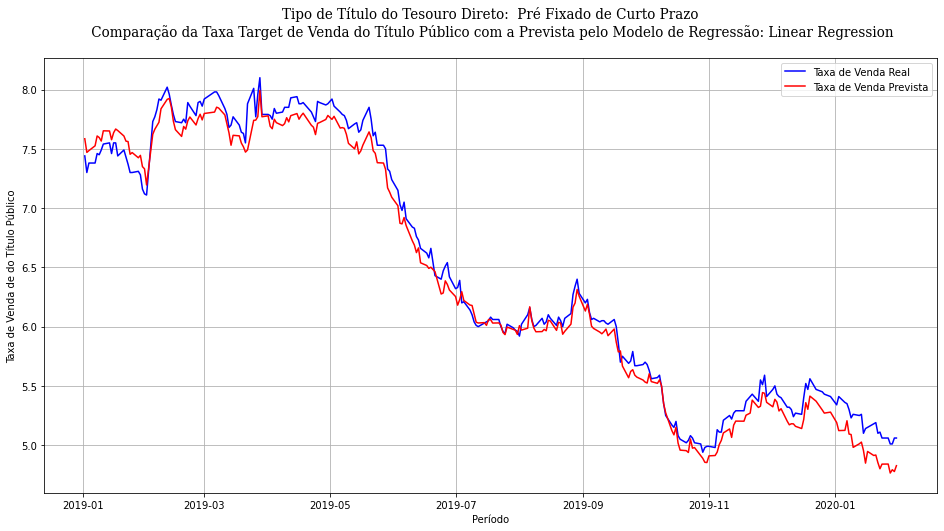

In [ ]:
#imprimir o gráfico do Modelo
imprimir_graficos_predicao('Linear Regression', y_test, predicted_rl)

In [ ]:
imprimir_scores_predicao("Regressão Linear", y_test, predicted_rl)

Regressão Linear  - MAE:   0.1126312392420243
Regressão Linear  - RMSE:  0.13014480078871063


## Modelo 3 - Regressão Linear com todas variáveis explicativas do dataframe dfTitulosIndicadores

### Criar os dataframes de Treinamento e Teste

In [ ]:
#Considerar nesse modelo todas as variáveis explicativas do as features do dataframe dfTitulosIndicadores
dfTitulosIndicadores = dfTitulosIndicadoresOriginal.copy()


In [ ]:
dfTitulosIndicadores.head()

,TaxaVendaTítulo,AnosVencimento,Selic,TaxaIPCA,TaxaJuros2Anos,TaxaJuros3Anos,TaxaJuros5Anos,PctIbovespaDiario,PctIbovespaMensal,PctIbovespaAnual
Data Base,,,,,,,,,,
2016-01-04,16.53,1.993196,14.25,10.67,16.530,16.680,16.560,-0.006964,-0.032941,-0.116482
2016-01-05,16.50,1.990458,14.25,10.67,16.455,16.655,16.500,-0.027889,-0.093737,-0.144371
2016-01-06,16.21,1.987720,14.25,10.67,16.160,16.340,16.165,0.006597,-0.087140,-0.107878
2016-01-07,16.07,1.984983,14.25,10.67,16.025,16.255,16.040,-0.015229,-0.102369,-0.102597
2016-01-08,16.15,1.982245,14.25,10.67,16.100,16.305,16.175,-0.025806,-0.105930,-0.138589


In [ ]:
#Criar os dataframe de Treinamento e Teste
df_train =  dfTitulosIndicadores[dfTitulosIndicadores.index >= data_inicio_treinamento]
df_train =  df_train[df_train.index <= data_fim_treinamento]
df_test = dfTitulosIndicadores[dfTitulosIndicadores.index >= data_inicio_teste]
df_test =  df_test[df_test.index <= data_fim_teste]

X_train = df_train.iloc[:,1:]
y_train = df_train[['TaxaVendaTítulo']]

X_test = df_test.iloc[:,1:]
y_test = df_test[['TaxaVendaTítulo']]

### Treinar e Testar o Modelo


In [ ]:
# Instancia o objeto
regressao_linear = LinearRegression( )

# Treina o modelo 
regressao_linear.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Valor do intercepto
regressao_linear.intercept_

array([-2.0935345])

In [ ]:
# Valor dos Coeficientes
regressao_linear.coef_

array([[ 0.52088404,  0.03912749,  0.0058807 ,  0.41230119,  0.22694033,
         0.37647788, -1.50203688, -0.18086872,  0.49572122]])

In [ ]:
X_train.columns

Index(['AnosVencimento', 'Selic', 'TaxaIPCA', 'TaxaJuros2Anos',
       'TaxaJuros3Anos', 'TaxaJuros5Anos', 'PctIbovespaDiario',
       'PctIbovespaMensal', 'PctIbovespaAnual'],
      dtype='object')

In [ ]:
X_test.head()

,AnosVencimento,Selic,TaxaIPCA,TaxaJuros2Anos,TaxaJuros3Anos,TaxaJuros5Anos,PctIbovespaDiario,PctIbovespaMensal,PctIbovespaAnual
Data Base,,,,,,,,,
2019-01-02,1.998672,6.5,3.75,7.35,8.11,8.525,0.028399,-0.019389,0.164227
2019-01-03,1.995934,6.5,3.75,7.31,7.93,8.370,0.035557,0.016168,0.199784
2019-01-04,1.993196,6.5,3.75,7.30,7.97,8.390,0.006065,0.024530,0.186360
2019-01-07,1.984983,6.5,3.75,7.35,8.01,8.420,0.003025,0.032646,0.179691
2019-01-08,1.982245,6.5,3.75,7.44,8.09,8.420,-0.001546,0.033279,0.178144


In [ ]:
y_test.head()

,TaxaVendaTítulo
Data Base,
2019-01-02,7.44
2019-01-03,7.30
2019-01-04,7.38
2019-01-07,7.38
2019-01-08,7.46


In [ ]:
# Realizar predições com o modelo de Regressão Linear
predicted_rl = regressao_linear.predict(X_test)

In [ ]:
predicted_rl

array([[7.34655792],
       [7.22988039],
       [7.2770695 ],
       [7.31357002],
       [7.37339168],
       [7.35053353],
       [7.29907739],
       [7.40739655],
       [7.40560687],
       [7.3247877 ],
       [7.39336077],
       [7.41953578],
       [7.40455924],
       [7.34911265],
       [7.32066834],
       [7.33120248],
       [7.17568865],
       [7.23228654],
       [7.16184225],
       [7.23457277],
       [7.08990864],
       [7.06137441],
       [6.93975193],
       [7.39179713],
       [7.43644398],
       [7.48467675],
       [7.57998729],
       [7.62000327],
       [7.69938401],
       [7.73306494],
       [7.62196556],
       [7.54003894],
       [7.42386672],
       [7.39111959],
       [7.49122446],
       [7.42697403],
       [7.53976432],
       [7.54648711],
       [7.47213082],
       [7.55103424],
       [7.56477652],
       [7.52379301],
       [7.60316884],
       [7.59244388],
       [7.65254817],
       [7.62646065],
       [7.54423206],
       [7.448

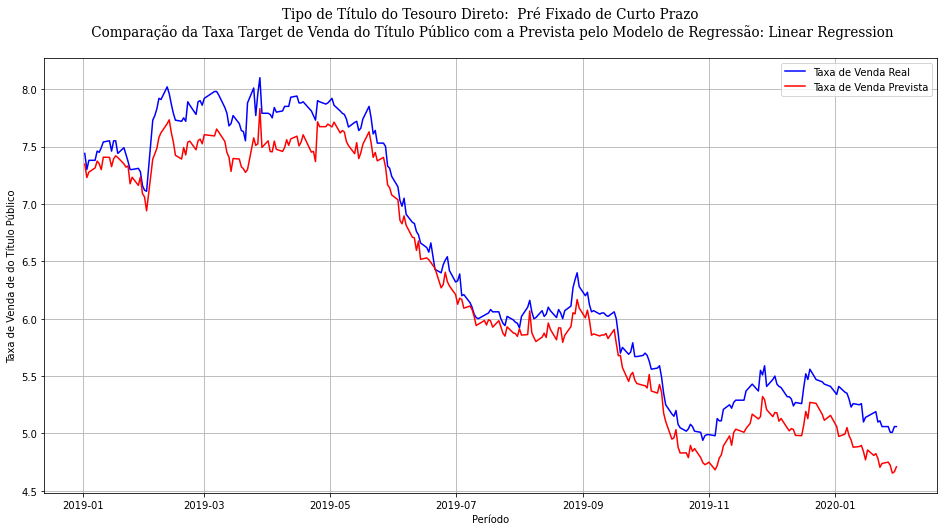

In [ ]:
#imprimir o gráfico do Modelo
imprimir_graficos_predicao('Linear Regression', y_test, predicted_rl)

In [ ]:
imprimir_scores_predicao("Regressão Linear", y_test, predicted_rl)

Regressão Linear  - MAE:   0.22329984030037126
Regressão Linear  - RMSE:  0.24461319585739483


## Modelo 4 - Regressão Linear com Prazo de Vencimento, Juros Futuros de 2 e 5 anos e Percentual Mensal de Variação do Ibovespa

### Criar os dataframes de Treinamento e Teste

In [ ]:
#Considerar nesse modelo as features de Prazo de Vencimento, TaxaJuros2Anos, TaxaJuros3Anos e PctIbovespaMensal
dfTitulosIndicadores = dfTitulosIndicadoresOriginal.copy()
dfTitulosIndicadores.drop(columns = ['Selic'], axis = 1, inplace=True)
dfTitulosIndicadores.drop(columns = ['TaxaIPCA'], axis = 1, inplace=True)
dfTitulosIndicadores.drop(columns = ['PctIbovespaDiario'], axis = 1, inplace=True)
dfTitulosIndicadores.drop(columns = ['PctIbovespaAnual'], axis = 1, inplace=True)
dfTitulosIndicadores.drop(columns = ['TaxaJuros3Anos'], axis = 1, inplace=True)


In [ ]:
dfTitulosIndicadores.head()

,TaxaVendaTítulo,AnosVencimento,TaxaJuros2Anos,TaxaJuros5Anos,PctIbovespaMensal
Data Base,,,,,
2016-01-04,16.53,1.993196,16.530,16.560,-0.032941
2016-01-05,16.50,1.990458,16.455,16.500,-0.093737
2016-01-06,16.21,1.987720,16.160,16.165,-0.087140
2016-01-07,16.07,1.984983,16.025,16.040,-0.102369
2016-01-08,16.15,1.982245,16.100,16.175,-0.105930


In [ ]:
#Criar os dataframe de Treinamento e Teste
df_train =  dfTitulosIndicadores[dfTitulosIndicadores.index >= data_inicio_treinamento]
df_train =  df_train[df_train.index <= data_fim_treinamento]
df_test = dfTitulosIndicadores[dfTitulosIndicadores.index >= data_inicio_teste]
df_test =  df_test[df_test.index <= data_fim_teste]

X_train = df_train.iloc[:,1:]
y_train = df_train[['TaxaVendaTítulo']]

X_test = df_test.iloc[:,1:]
y_test = df_test[['TaxaVendaTítulo']]

### Treinar e Testar o Modelo


In [ ]:
# Instancia o objeto
regressao_linear = LinearRegression( )

# Treina o modelo 
regressao_linear.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
# Valor do intercepto
regressao_linear.intercept_

array([-1.45674375])

In [ ]:
# Valor dos Coeficientes
regressao_linear.coef_

array([[ 0.53571414,  0.66483889,  0.34913068, -0.20528404]])

In [ ]:
X_train.columns

Index(['AnosVencimento', 'TaxaJuros2Anos', 'TaxaJuros5Anos',
       'PctIbovespaMensal'],
      dtype='object')

In [ ]:
X_test.head()

,AnosVencimento,TaxaJuros2Anos,TaxaJuros5Anos,PctIbovespaMensal
Data Base,,,,
2019-01-02,1.998672,7.35,8.525,-0.019389
2019-01-03,1.995934,7.31,8.370,0.016168
2019-01-04,1.993196,7.30,8.390,0.024530
2019-01-07,1.984983,7.35,8.420,0.032646
2019-01-08,1.982245,7.44,8.420,0.033279


In [ ]:
X_test.describe()

,AnosVencimento,TaxaJuros2Anos,TaxaJuros5Anos,PctIbovespaMensal
count,272.000000,272.000000,272.000000,272.000000
mean,2.377339,6.127121,7.250522,0.023914
std,0.301590,0.947556,0.877288,0.039827
min,1.916535,4.725000,5.845000,-0.061742
25%,2.102028,5.240000,6.453750,-0.003641
50%,2.369659,5.855000,6.920000,0.021043
75%,2.634551,7.165000,8.150000,0.048592
max,2.907657,7.540000,8.720000,0.138980


In [ ]:
y_test.head()

,TaxaVendaTítulo
Data Base,
2019-01-02,7.44
2019-01-03,7.30
2019-01-04,7.38
2019-01-07,7.38
2019-01-08,7.46


In [ ]:
# Realizar predições com o modelo de Regressão Linear
predicted_rl = regressao_linear.predict(X_test)

In [ ]:
predicted_rl

array([[7.48085821],
       [7.39138337],
       [7.38853439],
       [7.42618393],
       [7.48442282],
       [7.48503347],
       [7.45593527],
       [7.53347385],
       [7.52854753],
       [7.45983783],
       [7.50648654],
       [7.54343163],
       [7.52426646],
       [7.48789099],
       [7.42405853],
       [7.44273061],
       [7.33256648],
       [7.35728455],
       [7.28686507],
       [7.32794006],
       [7.22324553],
       [7.21819762],
       [7.0805812 ],
       [7.54921515],
       [7.60132192],
       [7.62736182],
       [7.66149934],
       [7.76570658],
       [7.85730362],
       [7.87155928],
       [7.78865036],
       [7.6700287 ],
       [7.59193741],
       [7.51986775],
       [7.61421453],
       [7.58935595],
       [7.65872013],
       [7.70490955],
       [7.64531469],
       [7.67662449],
       [7.72757853],
       [7.69248974],
       [7.74670879],
       [7.75334034],
       [7.79731205],
       [7.78841015],
       [7.71030276],
       [7.633

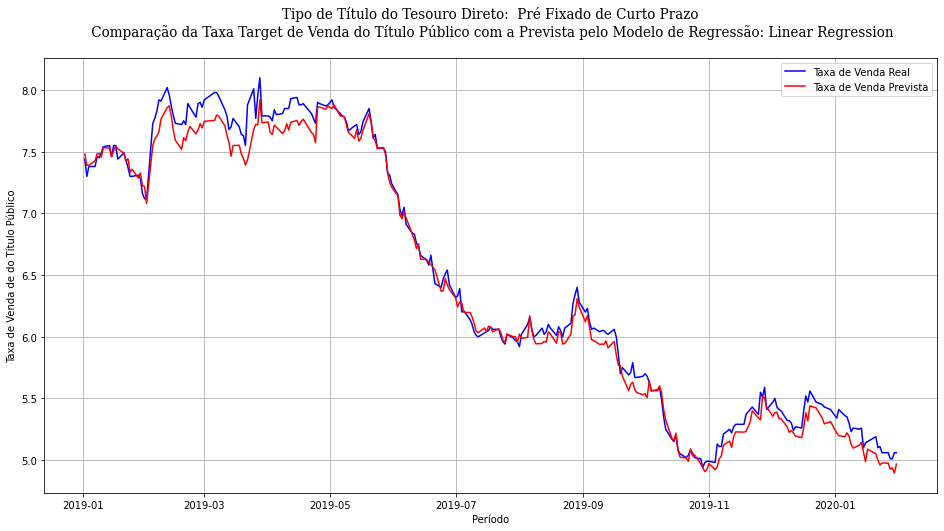

In [ ]:
#imprimir o gráfico do Modelo
imprimir_graficos_predicao('Linear Regression', y_test, predicted_rl)

In [ ]:
imprimir_scores_predicao("Regressão Linear", y_test, predicted_rl)

Regressão Linear  - MAE:   0.08362604494871684
Regressão Linear  - RMSE:  0.10624349497648304


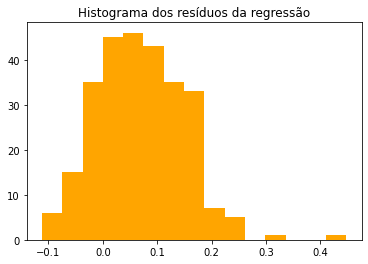

In [ ]:
residuos = y_test - predicted_rl  
plt.hist(residuos['TaxaVendaTítulo'], color='orange', bins=15)
plt.title('Histograma dos resíduos da regressão')
plt.show()

In [ ]:
residuos

,TaxaVendaTítulo
Data Base,
2019-01-02,-0.040858
2019-01-03,-0.091383
2019-01-04,-0.008534
2019-01-07,-0.046184
2019-01-08,-0.024423
2019-01-09,-0.035033
2019-01-10,0.034065
2019-01-11,0.006526
2019-01-14,0.021452


## Modelo 5 - LSTM (Long Short Term Memory)

In [ ]:
#o código abaixo foi adaptado a partir do Modelo LTSM contido no TCC "MODELOS PREDITIVOS UTILIZANDO SÉRIES TEMPORAIS DA BOLSA DE VALORES".
#o código python do TCC acima está no endereço: https://github.com/aly2009/ModelosPreditivos-BolsaValores.git

#Bibliotecas para utilização do Keras
from keras.models import Sequential
from keras.utils import plot_model
from keras.layers import LSTM, SimpleRNN, Dense, Dropout, Masking, Embedding

In [ ]:
#Carregamento dos dados
#Criar os dataframe de Treinamento e Teste
df_train =  dfTitulosIndicadores[dfTitulosIndicadores.index >= data_inicio_treinamento]
df_train =  df_train[df_train.index <= data_fim_treinamento]
df_test = dfTitulosIndicadores[dfTitulosIndicadores.index >= data_inicio_teste]
df_test =  df_test[df_test.index <= data_fim_teste]

train_lstm_td = df_train[['TaxaVendaTítulo']]
test_lstm_td = df_test[['TaxaVendaTítulo']]

In [ ]:
#Normalização dos dados
train_lstm = train_lstm_td.iloc[:,0:1].values # seleciona  a Taxa de Venda do Título do Tesouro Direto
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_scaled_lstm = scaler.fit_transform(train_lstm) 


In [ ]:
#Criação de uma estrutura de dados com 60 timesteps e 1 saída que neste caso será o valor de venda do título
timesteps = 60
x_train_lstm = []
y_train_lstm = []
for i in range(timesteps, train_lstm.shape[0]):
    x_train_lstm.append(train_scaled_lstm[i-timesteps:i, 0]) #Utilização de 60 timesteps anteriores
    y_train_lstm.append(train_scaled_lstm[i, 0]) #O 60º valor de venda será o valor de y
x_train_lstm, y_train_lstm = np.array(x_train_lstm), np.array(y_train_lstm)

In [ ]:
#Reshaping o dataset de treinamento 
#Sendo o segundo parâmetro como: 
       #x_train_lstm.shape[0] = batch_size, que é o número de taxas de venda do período de treinamento
       #x_train_lstm.shape[1] = time_step, que é o número de taxas anteriores
       #input_dim = 1, que indica que será usada a taxa de venda
x_train_lstm = np.reshape(x_train_lstm, (x_train_lstm.shape[0], x_train_lstm.shape[1], 1))

In [ ]:
x_train_lstm.shape

(684, 60, 1)

In [ ]:
#Criação da LSTM utilizando a biblioteca Keras
np.random.seed(1)

# Inicialização da RNN
model_rnn = Sequential()

#O parâmetro return_sequences=True indica que a rede terá mais camadas a frente
#O parâmetro Dropout ajuda no ajuste do Overfitting

# Adiciona a primeira camada LSTM com o Dropout 
model_rnn.add(LSTM(units = 128, return_sequences = True, input_shape = (x_train_lstm.shape[1], 1)))
model_rnn.add(Dropout(0.3))

# Adiciona a segunda camada LSTM com o Dropout
model_rnn.add(LSTM(units = 64))
model_rnn.add(Dropout(0.3))

# Adiciona a camada de saída 
#model_rnn.add(Dense(16,init='uniform',activation='relu'))
model_rnn.add(Dense(1,activation='linear'))

# Compila a RNN, neste caso utilizando o otimizador 'Adam'
model_rnn.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=['mean_absolute_error'])

# Faz o treinamento da RNN utilizando o dataset de treinamento
model_rnn.fit(x_train_lstm, y_train_lstm, epochs = 100, batch_size = 32) 

#Mostra o resumo do modelo
model_rnn.summary()

Epoch 1/100
22/22 [==============================] - 6s 102ms/step - loss: 0.0368 - mean_absolute_error: 0.1297
Epoch 2/100
22/22 [==============================] - 2s 100ms/step - loss: 0.0030 - mean_absolute_error: 0.0437
Epoch 3/100
22/22 [==============================] - 2s 102ms/step - loss: 0.0019 - mean_absolute_error: 0.0317
Epoch 4/100
22/22 [==============================] - 2s 102ms/step - loss: 0.0024 - mean_absolute_error: 0.0373
Epoch 5/100
22/22 [==============================] - 2s 99ms/step - loss: 0.0021 - mean_absolute_error: 0.0331
Epoch 6/100
22/22 [==============================] - 2s 102ms/step - loss: 0.0017 - mean_absolute_error: 0.0291
Epoch 7/100
22/22 [==============================] - 2s 101ms/step - loss: 0.0019 - mean_absolute_error: 0.0316
Epoch 8/100
22/22 [==============================] - 2s 103ms/step - loss: 0.0016 - mean_absolute_error: 0.0284
Epoch 9/100
22/22 [==============================] - 2s 103ms/step - loss: 0.0016 - mean_absolute_error: 

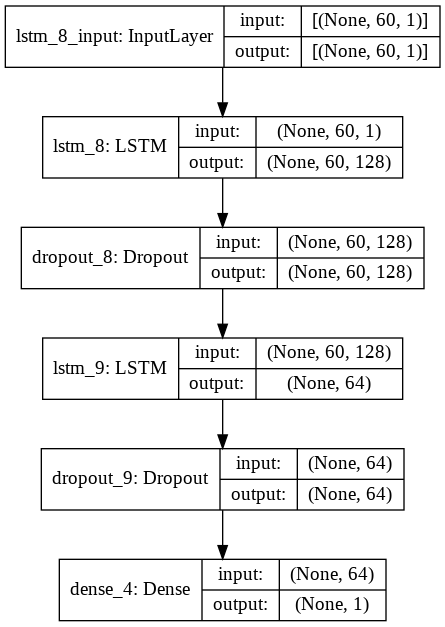

In [ ]:
#Visualização do modelo
plot_model(model_rnn, show_shapes=True) #Acrescente o parâmetro 'to_file='model_rnn.png' para exportar a figura

In [ ]:
#Carregamentos dos dados de teste para fazer as predições
test_lstm = test_lstm_td.iloc[:,0:1].values #seleciona o preço de fechamento

In [ ]:
# Concatena os dados de treinamento e teste, pois os preços de fechamento anteriores não estão no conjunto de teste
combine = pd.concat((train_lstm_td['TaxaVendaTítulo'], test_lstm_td['TaxaVendaTítulo']), axis = 0)

# Tratamento do conjunto de teste considerando os timesteps anteriores
test_inputs = combine[len(combine) - len(test_lstm_td) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)

# Normalização dos dados
test_inputs = scaler.transform(test_inputs)

In [ ]:
#Construção da Matriz de Teste x_test_ltsm
x_test_lstm = []
for i in range(timesteps, test_lstm_td.shape[0]+timesteps):
    x_test_lstm.append(test_inputs[i-timesteps:i, 0])
x_test_lstm = np.array(x_test_lstm)
x_test_lstm = np.reshape(x_test_lstm, (x_test_lstm.shape[0], x_test_lstm.shape[1], 1))


In [ ]:
# Predição utilizando os dados de teste
predictions_lstm = model_rnn.predict(x_test_lstm)

# Desnormaliza os dados
predictions_lstm = scaler.inverse_transform(predictions_lstm)

In [ ]:
predictions_lstm

array([[7.4833393],
       [7.4721327],
       [7.428545 ],
       [7.396127 ],
       [7.3778286],
       [7.3889217],
       [7.4105506],
       [7.441233 ],
       [7.480769 ],
       [7.5182242],
       [7.5261865],
       [7.5375085],
       [7.5489926],
       [7.5338135],
       [7.5196447],
       [7.496587 ],
       [7.4609113],
       [7.4113736],
       [7.3659406],
       [7.335248 ],
       [7.312246 ],
       [7.2712617],
       [7.2207456],
       [7.1744967],
       [7.279125 ],
       [7.448446 ],
       [7.6225967],
       [7.777771 ],
       [7.8853025],
       [7.969445 ],
       [8.010628 ],
       [8.001867 ],
       [7.95349  ],
       [7.884041 ],
       [7.8183055],
       [7.776322 ],
       [7.7488847],
       [7.771948 ],
       [7.807886 ],
       [7.822632 ],
       [7.84681  ],
       [7.8724484],
       [7.883687 ],
       [7.8982816],
       [7.924869 ],
       [7.9514456],
       [7.965039 ],
       [7.9444103],
       [7.9002576],
       [7.830367 ],


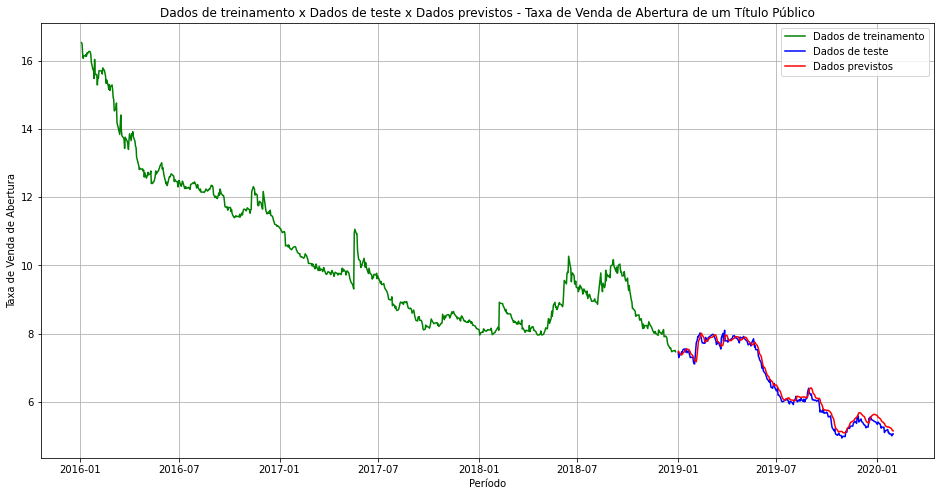

In [ ]:
#Plotagem dos dados de treinamento, teste e previsão
plt.figure(figsize=(16,8))
plt.plot(train_lstm_td.index, train_lstm_td, color='green', label = 'Dados de treinamento')
plt.plot(test_lstm_td.index, test_lstm, color = 'blue', label = 'Dados de teste')
plt.plot(test_lstm_td.index, predictions_lstm, color = 'red', label = 'Dados previstos')
plt.title('Dados de treinamento x Dados de teste x Dados previstos - Taxa de Venda de Abertura de um Título Público')
plt.xlabel('Período')
plt.ylabel('Taxa de Venda de Abertura')
plt.legend()
plt.grid(True)
#plt.savefig('lstm1.pdf')
plt.show()

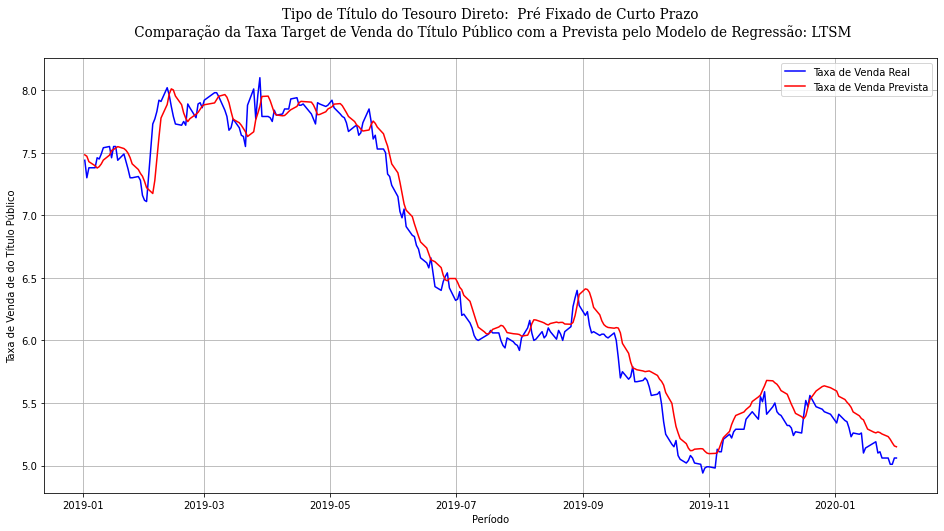

In [ ]:
imprimir_graficos_predicao("LTSM", test_lstm_td, predictions_lstm)

In [ ]:
#Imprimir scores da predição
imprimir_scores_predicao("LTSM", test_lstm_td, predictions_lstm)

LTSM  - MAE:   0.1196954187926124
LTSM  - RMSE:  0.14490155690552292


## Modelo Regressão Linear com Prazo de Vencimento, Juros Futuros de 2 e 5 anos e Percentual Mensal de Variação do Ibovespa - Polinomial


### Criar os dataframes de Treinamento e Teste

In [ ]:
#Considerar nesse modelo as features de Prazo de Vencimento, TaxaJuros2Anos e TaxaJuros3Anos
dfTitulosIndicadores = dfTitulosIndicadoresOriginal.copy()
dfTitulosIndicadores.drop(columns = ['Selic'], axis = 1, inplace=True)
dfTitulosIndicadores.drop(columns = ['TaxaIPCA'], axis = 1, inplace=True)
dfTitulosIndicadores.drop(columns = ['PctIbovespaDiario'], axis = 1, inplace=True)
dfTitulosIndicadores.drop(columns = ['PctIbovespaAnual'], axis = 1, inplace=True)
dfTitulosIndicadores.drop(columns = ['TaxaJuros3Anos'], axis = 1, inplace=True)




In [ ]:
dfTitulosIndicadores.head()

In [ ]:
#Criar os dataframe de Treinamento e Teste
df_train =  dfTitulosIndicadores[dfTitulosIndicadores.index >= data_inicio_treinamento]
df_train =  df_train[df_train.index <= data_fim_treinamento]
df_test = dfTitulosIndicadores[dfTitulosIndicadores.index >= data_inicio_teste]
df_test =  df_test[df_test.index <= data_fim_teste]

X_train = df_train.iloc[:,1:]
y_train = df_train[['TaxaVendaTítulo']]

X_test = df_test.iloc[:,1:]
y_test = df_test[['TaxaVendaTítulo']]

### Treinar e Testar o Modelo


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
tahminpolinom = PolynomialFeatures(degree=2)
Xyeni = tahminpolinom.fit_transform(X_train)
X_previsao = tahminpolinom.transform(X_test)

polinommodel = LinearRegression()
polinommodel.fit(Xyeni,y_train)
previpoli = polinommodel.predict(X_previsao)




In [ ]:
#imprimir o gráfico do Modelo
imprimir_graficos_predicao('Polynomial Regression', y_test, previpoli)

In [ ]:
imprimir_scores_predicao("Regressão Polinomial", y_test, previpoli)

## Regressão Ridge

### Criar os dataframes de Treinamento e Teste

In [ ]:
#Considerar nesse modelo as features de Prazo de Vencimento, TaxaJuros2Anos, TaxaJuros3Anos e PctIbovespaMensal
dfTitulosIndicadores = dfTitulosIndicadoresOriginal.copy()
dfTitulosIndicadores.drop(columns = ['Selic'], axis = 1, inplace=True)
dfTitulosIndicadores.drop(columns = ['TaxaIPCA'], axis = 1, inplace=True)
dfTitulosIndicadores.drop(columns = ['PctIbovespaDiario'], axis = 1, inplace=True)
dfTitulosIndicadores.drop(columns = ['PctIbovespaAnual'], axis = 1, inplace=True)
dfTitulosIndicadores.drop(columns = ['TaxaJuros3Anos'], axis = 1, inplace=True)




In [ ]:
dfTitulosIndicadores.head()

In [ ]:
#Criar os dataframe de Treinamento e Teste
df_train =  dfTitulosIndicadores[dfTitulosIndicadores.index >= data_inicio_treinamento]
df_train =  df_train[df_train.index <= data_fim_treinamento]
df_test = dfTitulosIndicadores[dfTitulosIndicadores.index >= data_inicio_teste]
df_test =  df_test[df_test.index <= data_fim_teste]

X_train = df_train.iloc[:,1:]
y_train = df_train[['TaxaVendaTítulo']]

X_test = df_test.iloc[:,1:]
y_test = df_test[['TaxaVendaTítulo']]

### Treinar e Testar o Modelo


In [ ]:
from sklearn.linear_model import Ridge
# Note that Ridge regression performs linear least squares with L2 regularization.
# Create and train the Ridge Linear Regression  Model
regression_model = Ridge(alpha=0.1)

regression_model.fit(X_train, y_train)


In [ ]:
# Make Prediction
predicted_ridge = regression_model.predict(X_test)


imprimir_graficos_predicao('Ridge Regression', y_test, predicted_ridge)


In [ ]:
#Imprimir scores da predição
imprimir_scores_predicao("Ridge Regression", y_test, predicted_ridge)

## LASSO (Least Absolute Shrinkage And Selection Operator regularization)

### Criar os dataframes de Treinamento e Teste

In [ ]:
#Considerar nesse modelo as features de Prazo de Vencimento, TaxaJuros2Anos, TaxaJuros3Anos e PctIbovespaMensal
dfTitulosIndicadores = dfTitulosIndicadoresOriginal.copy()
dfTitulosIndicadores.drop(columns = ['Selic'], axis = 1, inplace=True)
dfTitulosIndicadores.drop(columns = ['TaxaIPCA'], axis = 1, inplace=True)
dfTitulosIndicadores.drop(columns = ['PctIbovespaDiario'], axis = 1, inplace=True)
dfTitulosIndicadores.drop(columns = ['PctIbovespaAnual'], axis = 1, inplace=True)
dfTitulosIndicadores.drop(columns = ['TaxaJuros3Anos'], axis = 1, inplace=True)




In [ ]:
dfTitulosIndicadores.head()

In [ ]:
#Criar os dataframe de Treinamento e Teste
df_train =  dfTitulosIndicadores[dfTitulosIndicadores.index >= data_inicio_treinamento]
df_train =  df_train[df_train.index <= data_fim_treinamento]
df_test = dfTitulosIndicadores[dfTitulosIndicadores.index >= data_inicio_teste]
df_test =  df_test[df_test.index <= data_fim_teste]

X_train = df_train.iloc[:,1:]
y_train = df_train[['TaxaVendaTítulo']]

X_test = df_test.iloc[:,1:]
y_test = df_test[['TaxaVendaTítulo']]

### Treinar e Testar o Modelo


In [ ]:
from sklearn.linear_model import Lasso
#instanciar o modelo
lasso = Lasso(alpha = 0.01,positive=True)

#treinar o modelo
lasso.fit(X_train, y_train)

In [ ]:
#faz a predição
predicted_lasso = lasso.predict(X_test)

#imprimir o grafico
imprimir_graficos_predicao('LASSO Regression', y_test, predicted_lasso)

In [ ]:
#Imprimir scores da predição
imprimir_scores_predicao("LASSO Regression", y_test, predicted_lasso)

## Elastic Net

### Criar os dataframes de Treinamento e Teste

In [ ]:
#Considerar nesse modelo as features de Prazo de Vencimento, TaxaJuros2Anos, TaxaJuros3Anos e PctIbovespaMensal
dfTitulosIndicadores = dfTitulosIndicadoresOriginal.copy()
dfTitulosIndicadores.drop(columns = ['Selic'], axis = 1, inplace=True)
dfTitulosIndicadores.drop(columns = ['TaxaIPCA'], axis = 1, inplace=True)
dfTitulosIndicadores.drop(columns = ['PctIbovespaDiario'], axis = 1, inplace=True)
dfTitulosIndicadores.drop(columns = ['PctIbovespaAnual'], axis = 1, inplace=True)
dfTitulosIndicadores.drop(columns = ['TaxaJuros3Anos'], axis = 1, inplace=True)




In [ ]:
dfTitulosIndicadores.head()

In [ ]:
#Criar os dataframe de Treinamento e Teste
df_train =  dfTitulosIndicadores[dfTitulosIndicadores.index >= data_inicio_treinamento]
df_train =  df_train[df_train.index <= data_fim_treinamento]
df_test = dfTitulosIndicadores[dfTitulosIndicadores.index >= data_inicio_teste]
df_test =  df_test[df_test.index <= data_fim_teste]

X_train = df_train.iloc[:,1:]
y_train = df_train[['TaxaVendaTítulo']]

X_test = df_test.iloc[:,1:]
y_test = df_test[['TaxaVendaTítulo']]

### Treinar e Testar o Modelo


In [ ]:
from sklearn.linear_model import ElasticNet

# Instancia o objeto
en = ElasticNet(alpha=0.01, l1_ratio=0.1,max_iter=10000)

#treinar o modelo
en.fit(X_train, y_train)


In [ ]:
#faz a predição
predicted_elastic = en.predict(X_test)

#imprimir o grafico
imprimir_graficos_predicao("ELASTIC Regression", y_test, predicted_elastic)

In [ ]:
#Imprimir scores da predição
imprimir_scores_predicao("ELASTIC Regression", y_test, predicted_elastic)

## Random Forest Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
# Instancia o objeto
dtr = DecisionTreeRegressor(max_depth=8)

#treinar o modelo
dtr.fit(X_train, y_train)


In [ ]:
#faz a predição
predicted_dtr = dtr.predict(X_test)

#imprimir o grafico
imprimir_graficos_predicao("Decision Tree Regressor", y_test, predicted_dtr)

In [ ]:
#Imprimir scores da predição
imprimir_scores_predicao("Decision Tree Regressor", y_test, predicted_dtr)